45.23699352777778 14.202804555555554
min_lat: 45.23666002975406
max_lat: 45.23732702580149
min_lon: 14.201962599225382
max_lon: 14.203646511885726
Label 0: class=0, center_pixel=(4641.964800000001, 1589.8707), center_geo=(45.23696997614734, 14.20344302787985)
Label 1: class=0, center_pixel=(4732.75968, 1633.46139), center_geo=(45.23696018664636, 14.203471984441958)


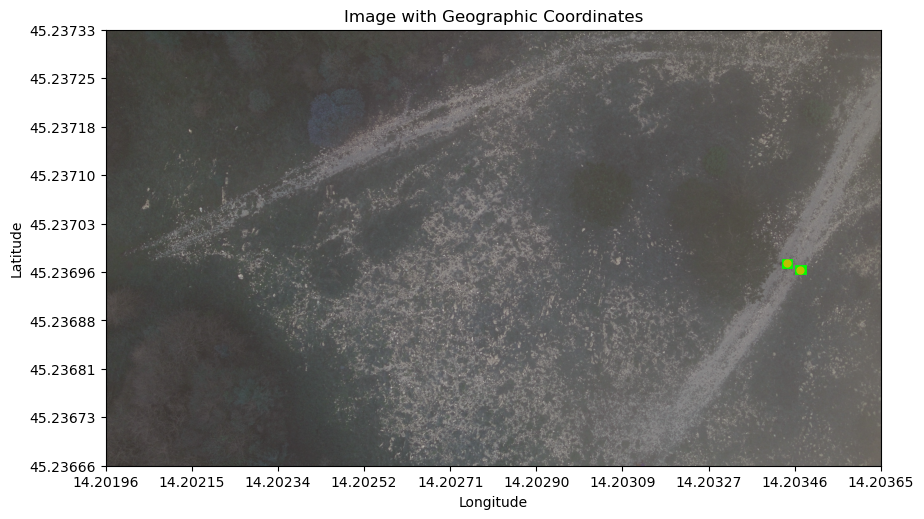

In [51]:
import os
from PIL import Image
from draw_utils import get_exif_data, get_lat_lon
import math
import numpy as np
import cv2

image_path = './detection/DJI_0004.JPG'
image = Image.open(image_path)

exif_data = get_exif_data(image)
lat, lon = get_lat_lon(exif_data)
print(lat, lon)

# Get image dimensions
width, height = image.size

# Assume a simple equirectangular projection for small areas
# Approximate meters per pixel at the given latitude

def meters_per_pixel(lat, zoom=18):
    # Earth's circumference at equator: 40075016.686 meters
    return 40075016.686 * math.cos(math.radians(lat)) / (2 ** (zoom + 8))

# Estimate ground sampling distance (GSD) if available, otherwise assume a value
# Here, let's assume GSD is not available, so we use a rough estimate:
# For DJI FC6520 (Zenmuse X5S) at 100m altitude, GSD ~ 2.5cm/pixel
# We'll use 0.025 meters/pixel as a placeholder
gsd = 0.025  # meters per pixel

# Calculate total width and height in meters
img_width_m = width * gsd
img_height_m = height * gsd

# Calculate degree offsets
# 1 deg latitude ~ 111320 meters
lat_offset = (img_height_m / 2) / 111320
# 1 deg longitude ~ 111320 * cos(latitude) meters
lon_offset = (img_width_m / 2) / (111320 * math.cos(math.radians(lat)))

min_lat = lat - lat_offset
max_lat = lat + lat_offset
min_lon = lon - lon_offset
max_lon = lon + lon_offset

print("min_lat:", min_lat)
print("max_lat:", max_lat)
print("min_lon:", min_lon)
print("max_lon:", max_lon)

# Read YOLO labels from DJI_0004.txt
yolo_label_path = './detection/DJI_0004.txt'
yolo_coords = []

with open(yolo_label_path, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) == 5:
            # YOLO format: class x_center y_center width height (all normalized)
            cls, x_c, y_c, w, h = map(float, parts)
            # Convert normalized to pixel coordinates
            x_center_px = x_c * width
            y_center_px = y_c * height
            w_px = w * width
            h_px = h * height
            # Get bounding box corners in pixel coordinates
            x_min_px = x_center_px - w_px / 2
            x_max_px = x_center_px + w_px / 2
            y_min_px = y_center_px - h_px / 2
            y_max_px = y_center_px + h_px / 2

            # Convert pixel coordinates to geographic coordinates
            # Latitude decreases as y increases (downward in image)
            lat_center = max_lat - (y_center_px / height) * (max_lat - min_lat)
            lon_center = min_lon + (x_center_px / width) * (max_lon - min_lon)

            yolo_coords.append({
                'class': int(cls),
                'pixel_bbox': [x_min_px, y_min_px, x_max_px, y_max_px],
                'center_pixel': (x_center_px, y_center_px),
                'center_geo': (lat_center, lon_center)
            })

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
img_name = "./detection/DJI_0004.JPG"
image = cv2.imread(img_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
np.set_printoptions(suppress=True)
plt.ticklabel_format(style='plain', useOffset=False)

ax.imshow(image)

for i, label in enumerate(yolo_coords):
    print(f"Label {i}: class={label['class']}, center_pixel={label['center_pixel']}, center_geo={label['center_geo']}")
    x_min, y_min, x_max, y_max = map(int, label['pixel_bbox'])
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='lime', facecolor='none')
    ax.add_patch(rect)
    ax.plot(label['center_pixel'][0], label['center_pixel'][1], 'yo', markersize=5)
    
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

num_ticks = 10
lat_ticks = np.linspace(max_lat, min_lat, num_ticks)
lon_ticks = np.linspace(min_lon, max_lon, num_ticks)

ax.set_yticks(np.linspace(0, height, num_ticks))
ax.set_yticklabels([f"{lat_tick:.5f}" for lat_tick in lat_ticks])

ax.set_xticks(np.linspace(0, width, num_ticks))
ax.set_xticklabels([f"{lon_tick:.5f}" for lon_tick in lon_ticks])

plt.title("Image with Geographic Coordinates")
plt.show()

# Check predictions

In [9]:
import json
import glob
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

os.makedirs('./labeled', exist_ok=True)

# Read predictions from JSON file
with open('./predictions.json', 'r') as f:
    predictions = json.load(f)

# Get all .jpg images in the ./detection folder
image_files = glob.glob('./dataset/images/test/*.JPG')

# Loop through each image
for img_path in image_files:
    img_name = os.path.basename(img_path)
    print(f"Processing image: {img_name}")
    image = cv2.imread(img_path)

    for pred in predictions:
        if pred.get('image_id') == img_name[:-4]:
            if pred.get('score') > 0.5:
                print(f"Image: {img_name}, BBox: {pred.get('bbox')}")
                x, y, w, h = np.array(pred.get('bbox'), dtype=int)
                x_min, y_min = x, y
                x_max, y_max = x + w, y + h
                
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 20)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)                
                save_path = os.path.join('./labeled', img_name)
                plt.imsave(save_path, image_rgb)

Processing image: flight_1_DJI_0012.JPG
Processing image: flight_1_DJI_0033.JPG
Processing image: flight_1_DJI_0042.JPG
Image: flight_1_DJI_0042.JPG, BBox: [3320.673, 1439.021, 46.852, 46.031]
Processing image: flight_1_DJI_0043.JPG
Processing image: flight_1_DJI_0065.JPG
Image: flight_1_DJI_0065.JPG, BBox: [3895.47, 1959.253, 57.074, 55.253]
Processing image: flight_1_DJI_0071.JPG
Image: flight_1_DJI_0071.JPG, BBox: [3123.579, 1367.514, 53.794, 54.498]
Processing image: flight_1_DJI_0079.JPG
Image: flight_1_DJI_0079.JPG, BBox: [4097.906, 1637.986, 59.243, 56.002]
Processing image: flight_1_DJI_0080.JPG
Processing image: flight_1_DJI_0083.JPG
Processing image: flight_1_DJI_0096.JPG
Processing image: flight_1_DJI_0110.JPG
Image: flight_1_DJI_0110.JPG, BBox: [4367.003, 1617.713, 65.406, 64.142]
Processing image: flight_1_DJI_0112.JPG
Image: flight_1_DJI_0112.JPG, BBox: [3878.956, 716.932, 57.866, 57.537]
Processing image: flight_1_DJI_0114.JPG
Image: flight_1_DJI_0114.JPG, BBox: [2517.64

45.11791619444445 14.195926972222223
GimbalYawDegree: -132.6


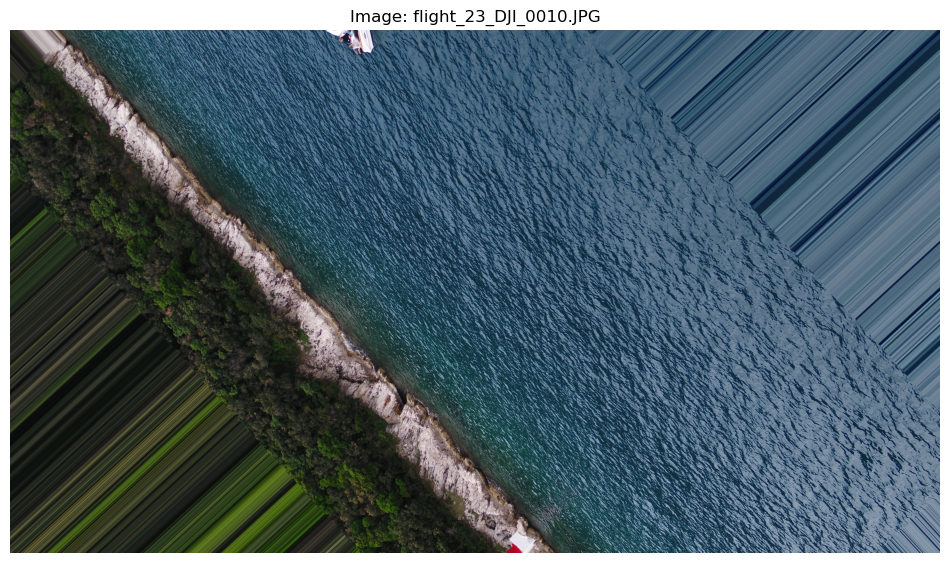

In [48]:
from PIL import Image
import re

image = './dataset/images/test/flight_23_DJI_0010.JPG'

img_exif = Image.open(image)
exif_data = get_exif_data(img_exif)
lat, lon = get_lat_lon(exif_data)
print(lat, lon)

# Save exif_data to a txt file called exif
with open('exif.txt', 'w', encoding='utf-8') as f:
    for key, value in exif_data.items():
        f.write(f"{key}: {value}\n")

fd = open(image, encoding = 'latin-1')
d= fd.read()
xmp_start = d.find('<x:xmpmeta')
xmp_end = d.find('</x:xmpmeta')
xmp_str = d[xmp_start:xmp_end+12]
match = re.search(r'drone-dji:GimbalYawDegree="([-\d.]+)"', xmp_str)
gimbal_yaw = float(match.group(1)) if match else None

print("GimbalYawDegree:", gimbal_yaw)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
show = cv2.imread(image)
show = cv2.cvtColor(show, cv2.COLOR_BGR2RGB)
center = (show.shape[1] // 2, show.shape[0] // 2)
rot_mat = cv2.getRotationMatrix2D(center, -gimbal_yaw, 1.0)  # negative for image coordinates
rotated = cv2.warpAffine(show, rot_mat, (show.shape[1], show.shape[0]), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
plt.imshow(rotated)
plt.axis('off')
plt.title("Image: " + os.path.basename(image))
plt.show()

In [47]:
def json_bbox_to_yolo_bbox(bbox, img_width, img_height):
    """
    Convert COCO JSON bbox format [x_min, y_min, width, height] to YOLO format [x_center, y_center, w, h] (normalized).
    bbox: list or tuple of [x_min, y_min, width, height]
    img_width: int, image width in pixels
    img_height: int, image height in pixels
    Returns: [x_center_norm, y_center_norm, w_norm, h_norm]
    """
    x_min, y_min, w, h = bbox
    x_center = x_min + w / 2
    y_center = y_min + h / 2
    x_center_norm = x_center / img_width
    y_center_norm = y_center / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    return [x_center_norm, y_center_norm, w_norm, h_norm]

In [48]:
def yolo_bbox_to_opencv_bbox(yolo_bbox, img_width, img_height):
    """
    Convert YOLO bbox format [x_center, y_center, w, h] (normalized) to OpenCV format [x_min, y_min, x_max, y_max] (pixels).
    yolo_bbox: list or tuple of [x_center, y_center, w, h] (all normalized)
    img_width: int, image width in pixels
    img_height: int, image height in pixels
    Returns: [x_min, y_min, x_max, y_max] (all int)
    """
    x_center, y_center, w, h = yolo_bbox
    x_center_px = x_center * img_width
    y_center_px = y_center * img_height
    w_px = w * img_width
    h_px = h * img_height

    x_min = int(round(x_center_px - w_px / 2))
    y_min = int(round(y_center_px - h_px / 2))
    x_max = int(round(x_center_px + w_px / 2))
    y_max = int(round(y_center_px + h_px / 2))

    return [x_min, y_min, x_max, y_max]